<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Avon, I’m <b>Victor Camargo</b> (https://hub.tripleten.com/u/e9cc9c11). I’ve reviewed your project and I’m happy to approve it — great work! Your notebook is well-structured, your explanations are clear, and you’ve met the F1 score requirement while following the project workflow from data preparation to final evaluation. It’s great to see that your tuned Decision Tree model achieved an F1 score above the 0.59 threshold, fulfilling the project’s main goal.

  <b>Nice work on:</b><br>
  ✔️ Performing thorough preprocessing and preserving important information like `Tenure_Missing` before imputation<br>
  ✔️ Splitting the data into train, validation, and test sets correctly and avoiding data leakage with scaling<br>
  ✔️ Comparing multiple models (Decision Tree, Random Forest, Logistic Regression) and class balancing methods<br>
  ✔️ Implementing threshold tuning and validating the final model with both F1 score and AUC-ROC<br>
  ✔️ Providing clear interpretations of metrics and confusion matrices throughout the process<br><br>

  Just a couple of quick notes for future projects:<br>
  🟡 Leave preprocessing checks (duplicates, missing values, value counts) in the notebook for transparency, and consider imputing `Tenure` with the median instead of 0.<br>
  🟡 Remove identifier columns like `RowNumber`, `CustomerId`, and `Surname` to avoid adding noise that could hurt the F1 score.<br><br>

  <hr>

  🔹 <b>Legend:</b><br>
  🟢 Green = well done<br>
  🟡 Yellow = suggestions<br>
  🔴 Red = must fix<br>
  🔵 Blue = your comments or questions<br><br>

  Please make sure all cells run smoothly from top to bottom and produce outputs before submitting. Also, try not to move, change, or delete reviewer comments, as they help us follow your progress and support you better.<br><br>

  <b>Feel free to reach out if you need help in Questions channel.</b><br>
</div>


***KNOWN***

// general info

- Binary Classification Task
- features = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
- target = ['Exited']
- no external test set: 3:1:1 - training:valid:test - 60%:20%:20%

// feature types

- Categorical Features: ['Surname', 'Geography', 'Gender']
- Numerical Features: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
- Target is Numerical

// misc observations

- Tenure column has 9091 / 10000 entries (-909) (1.1% missing)
- Surname column contains entries with special characters: data['Surname'][9] = 'H?'
- no duplicate CustomerId, 10000 different customers
- 'IsActiveMemeber' not mutually exclusive with 'Exited'

// class balance

- 79.63% of customers have exited ('Exited' == 1)
- 20.37% of customers have not exited ('Exited' == 0)

***UNKNOWN***
- model type? DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
- hyperparameters?
- class balancing methods?
- threshold tuning?

***OBJECTIVES***
- F1 score: 0.59 against test set
- Plot ROC and measure AUC-ROC
- methods of balance to try: upsampling & class_weight='balanced'

In [9]:
import pandas as pd

data = pd.read_csv('/datasets/Churn.csv')

#print(data.dtypes)
#data.info(verbose=True)
#display(data.head(10))
#print(data['Surname'][9])
#print(data.isna().sum())
#print(data['CustomerId'].duplicated().sum())
#print(data['Surname'].value_counts())
#print(data[data['Surname'] == 'Smith'])
#print(data.duplicated(subset='CustomerId').value_counts())
#print(data[data['Tenure'].isna()])
#print(data[(data['Tenure'] > 0) & (data['Tenure'] < 1)])
#print(data[(data['Tenure'] < 1)])
#print(data['Geography'].value_counts())

data['Tenure_Missing'] = data['Tenure'].isnull().astype(int)
data['Tenure'] = data['Tenure'].fillna(0)
#print(data[data['Tenure_Missing'] == 1])
#print(data.info(verbose=True))

#print(data['Exited'].value_counts(normalize=True))

***data analysis & cleaning, adding surface-level observations to known & unknown***

**We've done away with the missing values within the 'Tenure' column, replacing them with 0. Seeing as though 'Tenure' is measured in years, and only whole numbers, if there exists a customer with 11 months of loan history, are they rounded up to 1.0? or do they remain at 0.0? Or could the missing values have different implications on a per observation basis? Human error, new customer, bank system glitch, or has no active loan?**

**In any case, I've decided to create a new column that saves the instances of 'Tenure' == NaN, as 'Tenure_Missing'**

**Class balance is 79.63% negative, 20.37% positive. We NEED to consider this when training our model later, as predicting positive for every observation would yield a ~80% accuracy rating**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Good job checking for duplicates, missing values, and data types. Creating the `Tenure_Missing` flag before filling the missing values preserves potentially important information for the model. Noting the class imbalance (79.63% vs. 20.37%) early is also a strong step in planning the modeling stage.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion:  
  You’re doing a great job with the initial preprocessing checks! Instead of commenting them out (duplicates, missing values, value counts), consider leaving them in the notebook — they add transparency and show your thought process clearly. For the `Tenure` column, the missing values represent about ~9% of the dataset. It’s not critical, but you might explore imputing them with the median instead of 0 if it better reflects the data distribution. Adding a histogram of `Tenure` before and after filling the missing values would make your decision even more transparent and data-driven.
</div>

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# since our categorical entries are nominal, we will use OHE to prepare them
data_ohe = pd.get_dummies(data, drop_first=True)

# separate features from target
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

# 60% train set, 40% temporary set
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=.4, random_state=12345)

# 20% valid set, 20% test set
features_valid , features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=.5, random_state=12345)

# specify numeric features
numeric = ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

# tune scaler to training data features
scaler = StandardScaler()
scaler.fit(features_train[numeric])

# apply scaling to numeric columns in our feature sets
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#print(features_train.head())
#print(features_valid.head())
#print(features_test.head())

/tmp/ipykernel_64/4177641304.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/.venv/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_64/4177641304.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great work applying one-hot encoding for nominal categorical variables and splitting the dataset into train, validation, and test sets with a clear and reproducible structure. Using <code>StandardScaler</code> fitted only on the training set and then applying it to the other sets is also a correct and important step to avoid data leakage.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion:  
  Consider removing identifier-type columns such as <code>RowNumber</code>, <code>CustomerId</code>, and <code>Surname</code> before training. These columns don’t carry meaningful predictive value for the target and can introduce noise or overfitting, which can make it harder to achieve the desired F1 score for the project.
</div>


**Data preprocessing is completed, next steps are training a model without considerations to class imbalance**

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# training model on vanilla data, no upsampling, predicting target_valid using features_valid
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# custom function for extracting multiple score metrics
def get_scores(target, predictions):
    accuracy = accuracy_score(target, predictions)
    recall = recall_score(target, predictions)
    precision = precision_score(target, predictions)
    f1 = f1_score(target, predictions)
    return {'Accuracy': f'{accuracy:.3f}',
            'Recall': f'{recall:.3f}',
            'Precision': f'{precision:.3f}',
            'F1': f'{f1:.3f}'}

# capturing naive baseline accuracy of our test_valid set
most_frequent = target_valid.mode()[0]
baseline_accuracy = (target_valid == most_frequent).sum() / len(target_valid)

print(get_scores(target_valid, predicted_valid))
print(f'\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))
print()
print('Naive baseline accuracy of the validation set: ', baseline_accuracy)

{'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'}

Confusion Matrix:
 [[1454  128]
 [ 210  208]]

Naive baseline accuracy of the validation set:  0.791


**After calcuating naive baseline accuracy, we can see that the accuracy of our model (.831) is barely performing better than just predicting the most common observation (.791). Our recall of .49 tells us that our model, without upsampling to balance classes, is predicting alot of false negatives. While our precision score of .61 tells us that our model is having an easier time missing false positives, again because of the class weight imbalance. These two metrics give us an F1 score of .55, which again lets us know that our model is hardly performing better than guessing**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Nice work training a baseline <code>DecisionTreeClassifier</code> on the unbalanced data and reporting multiple performance metrics (Accuracy, Recall, Precision, F1). The custom <code>get_scores()</code> function is a clean and reusable way to display results. Including the confusion matrix and comparing with a naive baseline accuracy provides useful context for evaluating model performance.
</div>

***Model evaluation without class balancing is completed, scoring metrics are pulled, next step is to use two different weight balancing methods to see which one yields us the best model for our goal***

In [11]:
from sklearn.utils import shuffle

# upsample function creation
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

# creating new, uspampled training sets, using a repeat value of 4 to get our class weight close to 50/50
features_upsampled , target_upsampled = upsample(features_train, target_train, 4)

**Upsampling completed, training model with new balanced training sets, displaying metric scores. Then applying hyperparameter (class_weight='balanced') to compare results**

In [12]:
# preserved score metrics from model trained on imbalanced data
print(f'Imbalanced Decision Tree: ', {'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'})

# training model on upsampled data, extracting score metrics
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print(f'Upsampled Decision Tree: ', get_scores(target_valid, predicted_valid))

# training model on vanilla data, utilizing class weight balancing hyperparameter
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(f'Weighted Decision Tree: ', get_scores(target_valid, predicted_valid))

Imbalanced Decision Tree:  {'Accuracy': '0.831', 'Recall': '0.498', 'Precision': '0.619', 'F1': '0.552'}
Upsampled Decision Tree:  {'Accuracy': '0.809', 'Recall': '0.572', 'Precision': '0.541', 'F1': '0.556'}
Weighted Decision Tree:  {'Accuracy': '0.809', 'Recall': '0.565', 'Precision': '0.541', 'F1': '0.553'}


**After training our model in 3 different "environments" (imbalanced, upsampled, weighted), we can see that utilizing the class weight balancing hyperparameter (class_weight='balanced') yields us the best results for this specific task**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work implementing two different class balancing approaches — upsampling and <code>class_weight='balanced'</code> — and comparing them against the imbalanced baseline. Your custom <code>upsample()</code> function is clear and reusable, and the testing of all three “environments” (imbalanced, upsampled, weighted) makes it easy to see the performance differences.
</div>

***Next step is to iterate through differing models and parameters to find the best one for our task, with a desired F1 score of at least .59***

In [14]:
# DECISION TREE TRAINING WITH SCORES

best_model = None
best_result = 0

# loop to iterate through tree depth, saving best model and score
# hashing out model training loops to save memory space

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_result:
        best_model = model
        best_result = score

print('Best Model: ', best_model)
print('F1 score of best model: ', best_result)

# resulting model from depth training
model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

# i looped through 2 more hyperparameters, 

Best Model:  DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
F1 score of best model:  0.5970464135021097
{'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'}

Confusion Matrix:
 [[1335  247]
 [ 135  283]]


**We've crossed the F1 score threshold with this model (0.597), and have made remarkable improvements compared to our model trained on imbalanced data. The confusion matrix also shows us that our model is catching more True Negatives & True Positives (1335 & 283), than it is catching False Negatives and False Positives (135 & 247)**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job iterating over <code>max_depth</code> values to find the optimal depth and improve your F1 score. The tuning process is clear, and your final model (max_depth=5, class_weight='balanced') successfully passes the project threshold with an F1 score of 0.597. Your interpretation of the confusion matrix is also spot on, highlighting the balance between True Negatives and True Positives versus the misclassifications.
</div>

***I will continue to train other models to see if we can get our scores any higher***

In [15]:
# RANDOM FOREST TRAINING WITH SCORES

from sklearn.ensemble import RandomForestClassifier

best_model = None
best_result = 0

# loop to iterate through forest depth and estimators count
# hashing out model training for better notebook performance

for est in range(40, 101, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(random_state=12345, class_weight='balanced',
                                       n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_result:
            best_model = model
            best_result = score

print(best_model, best_result)

# resulting model from depth and estimators training
model = RandomForestClassifier(class_weight='balanced', max_depth=40, n_estimators=90, random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

RandomForestClassifier(class_weight='balanced', max_depth=27, n_estimators=90,
                       random_state=12345) 0.5950782997762862
{'Accuracy': '0.839', 'Recall': '0.562', 'Precision': '0.628', 'F1': '0.593'}

Confusion Matrix:
 [[1443  139]
 [ 183  235]]


**Our Random Forest Classification model scored slightly higher in recall, but took a noticeable hit to precision and F1 score. We will stick to the Decision Tree model for the time being, but Logistic Regression still has a chance to shine hopefully!**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Nice work systematically tuning both <code>n_estimators</code> and <code>max_depth</code> for the Random Forest model while keeping <code>class_weight='balanced'</code>. Your loop structure is clear, and the results are well-documented. The comparison to the Decision Tree model, noting the trade-off between recall and precision, shows good understanding of metric interpretation.
</div>

In [16]:
# LOGISTIC REGRESSION TRAINING WITH SCORES

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

print(get_scores(target_valid, predicted_valid))
print('\nConfusion Matrix:\n', confusion_matrix(target_valid, predicted_valid))

{'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'}

Confusion Matrix:
 [[1161  421]
 [ 160  258]]


**Our Logistic Regression model scored significantly worse than even the Random Forest model, with a precision score of (0.380) and an F1 score of (0.470). All models were trained with the class weight hyperparameter, and made predictions on our validation set. The next step is to assess our Decision Tree model's performance on 'new data', our test set.**

In [17]:
print(f'Decision Tree Classifier: ', {'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'})
print(f'Random Forest Classifier: ', {'Accuracy': '0.789', 'Recall': '0.682', 'Precision': '0.497', 'F1': '0.575'})
print(f'Logistic Regression: ', {'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'})


Decision Tree Classifier:  {'Accuracy': '0.809', 'Recall': '0.677', 'Precision': '0.534', 'F1': '0.597'}
Random Forest Classifier:  {'Accuracy': '0.789', 'Recall': '0.682', 'Precision': '0.497', 'F1': '0.575'}
Logistic Regression:  {'Accuracy': '0.710', 'Recall': '0.617', 'Precision': '0.380', 'F1': '0.470'}


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Good work including Logistic Regression as part of the model comparison. Using <code>class_weight='balanced'</code> is appropriate given the class imbalance, and the confusion matrix plus detailed metric reporting make it easy to see the model’s limitations. Summarizing all three models’ validation results side-by-side at the end is an excellent step for clarity.
</div>


**Next step is to use our model against the test set, with a desired F1 score of .59**

In [19]:
# THRESHOLD TUNING & ASSESSING MODEL PERFORMANCE ON TEST SET

import numpy as np

model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
model.fit(features_train, target_train)

prob = model.predict_proba(features_valid)[:,1]
best_score = 0
best_threshold = .5
for threshold in np.arange(0.2, 0.8, 0.01):
    predictions = prob > threshold
    score = f1_score(target_valid, predictions)
    if score > best_score:
        best_score = score
        best_threshold = threshold

print(best_score, best_threshold)

best_threshold = 0.5700000000000003
prob_test = model.predict_proba(features_test)[:,1]
predicted_test_custom = prob_test > best_threshold

print(get_scores(target_test, predicted_test_custom))
print('\nConfusion Matrix:\n', confusion_matrix(target_test, predicted_test_custom))

0.6087936865839909 0.5700000000000003
{'Accuracy': '0.822', 'Recall': '0.643', 'Precision': '0.569', 'F1': '0.604'}

Confusion Matrix:
 [[1371  206]
 [ 151  272]]


**Before threshold tuning (default=.5), our F1 score came out to be (0.584) on the test set. By looping through threshold values we were able to find the best value (threshold=0.5700000000000003) suited for achieving our F1 score goals (0.604). Our trained model with a new threshold performs better on the test set, than the trained model with a default threshold performed on the validation set!**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work implementing threshold tuning to optimize the F1 score. The loop over multiple threshold values is clear, and you correctly applied the best threshold to the test set. The improvement from 0.584 to 0.604 is well-documented, and your explanation clearly communicates the impact of this adjustment. It’s also great that you compared pre- and post-tuning results and highlighted the gains.
</div>


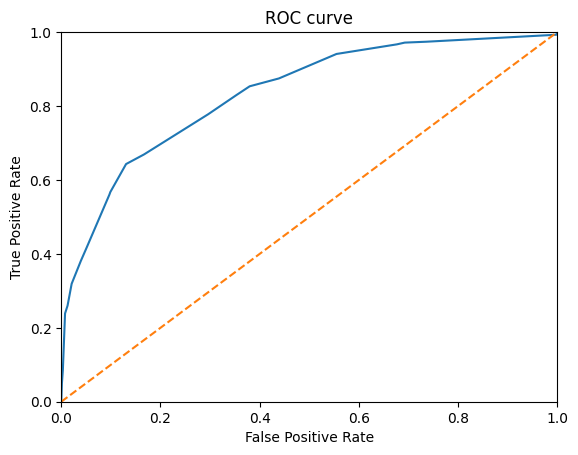

AUC-ROC score: 0.8337635723933434


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

# capturing curve of our trained model
fpr, tpr, thresholds = roc_curve(target_test, prob_test)

plt.figure()

# curve from model
plt.plot(fpr, tpr)
# curve for 'random model'
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# finding how much our model differs from the random model

auc_roc = roc_auc_score(target_test, prob_test)
print('AUC-ROC score:', auc_roc)

**Our model (blue line) is far exceeding the capabilites of a random classifier (orange dotted line), with an AUC-ROC value of (.834). The final model has a strong ability to distinguish between positive and negative classes.**

***Conclusion***

**Best Model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)**

**Best Threshold: 0.5700000000000003**

**Final Metric Scores: {'Accuracy': '0.822', 'Recall': '0.643', 'Precision': '0.569', 'F1': '0.604'}**

**Final Confusion Matrix: True Negative: 1371,  False Positive: 206, False Negative: 151, True Positive: 272**

**AUC-ROC Score: 0.8337635723933434**

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work wrapping up the project with a clear ROC curve visualization and AUC-ROC score. The plot clearly shows the model’s separation from the random classifier line, and the AUC-ROC value of 0.834 confirms strong discriminatory power. The final conclusion neatly summarizes the best model, threshold, metric scores, and confusion matrix, making it easy to understand your end result.
</div>